In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import powerlaw
import os
import numpy as np 
import matplotlib.pyplot as plt 


In [3]:


##### Get WD
 
def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            return current_path
       
        parent_path = os.path.dirname(current_path)
       
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
       
        current_path = parent_path
 
    return None  # Return None if not found
 
root = find_repo_root(os.getcwd())
root = root.replace('\\', '/')
root

'c:/Users/fitsl/Documents/Programming/UVM Programming Classes/Data Science I/Project'

In [4]:
df = pd.read_csv(f"{root}/Data/County/By_county_clean/bycounty_2015_2019.csv")
df_top = df.sort_values(by='County_to_county_movers', ascending=False).head(20)
df_top[[
    'Current_state', 'Current_county', 'Past_state', 'Past_county', 'County_to_county_movers'
]]

,Current_state,Current_county,Past_state,Past_county,County_to_county_movers
17891,California,Los Angeles County,Asia,-,37932.0
18934,California,Orange County,California,Los Angeles County,37436.0
20585,California,San Bernardino County,California,Los Angeles County,36835.0
17175,California,Los Angeles County,California,Orange County,25557.0
19678,California,Riverside County,California,Los Angeles County,24338.0
35400,Florida,Broward County,Florida,Miami-Dade County,24255.0
23343,California,Santa Clara County,Asia,-,23067.0
157775,New York,Kings County,New York,New York County,22210.0
262930,Washington,Snohomish County,Washington,King County,21995.0
230562,Texas,Fort Bend County,Texas,Harris County,21108.0


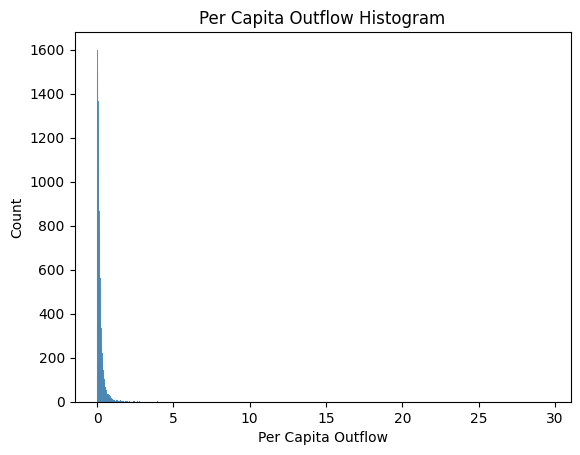

In [5]:
df1 = pd.read_csv(f"{root}/Data/FINAL_FOR_MODEL/FJK_Agg_Sets/From_2000.csv", 
                #   usecols=['STATE_FIPS', 'COUNTY_FIPS'], 
                  dtype= {
    'STATE_FIPS': str,
    'COUNTY_FIPS':str
})


df1['Outflow_pc'].sort_values(ascending=False)
upper_bound = np.percentile(df1['Outflow_pc'], 99)
lower_bound = np.percentile(df1['Outflow_pc'], 1)

# df1 = df1[df1['Outflow_pc'] <= upper_bound]
# df1 = df1[df1['Outflow_pc'] >= lower_bound]

import seaborn as sns
fig = plt.figure()
sns.histplot(data=(df1['Outflow_pc']))
plt.xlabel("Per Capita Outflow")
plt.title("Per Capita Outflow Histogram")
plt.savefig(f"{root}/Figures/Main/per_capita_histogram_unfixed")


# sns.histplot(data=df1[df1['Inflow_pc'] <= .7]['Inflow_pc'])
# sns.histplot(data=df1[df1['Inflow_pc'] > .7]['Inflow_pc'])



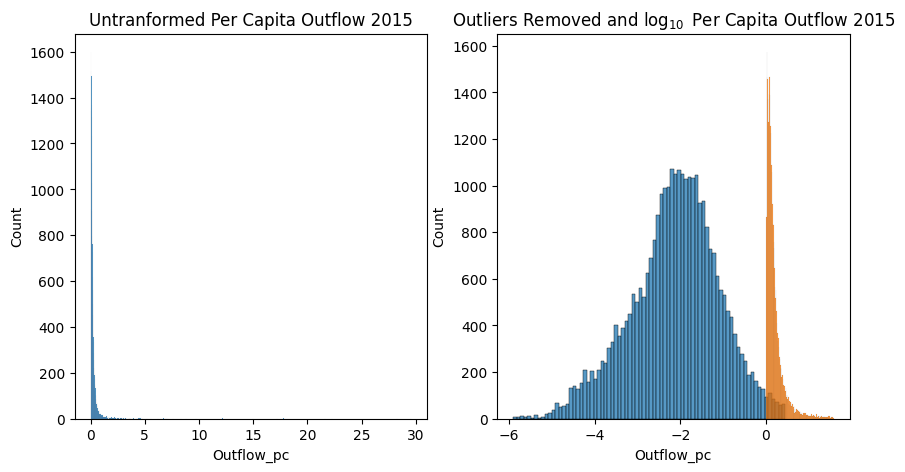

In [18]:
df1 = pd.read_csv(f"{root}/Data/FINAL_FOR_MODEL/FJK_Agg_Sets/From_2000.csv", 
                #   usecols=['STATE_FIPS', 'COUNTY_FIPS'], 
                  dtype= {
    'STATE_FIPS': str,
    'COUNTY_FIPS':str
})


df1['Outflow_pc'].sort_values(ascending=False)


import seaborn as sns
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(10,5))


sns.histplot(data=(df1['Outflow_pc']), ax=ax1)
upper_bound = np.percentile(df1['Outflow_pc'], 99)
lower_bound = np.percentile(df1['Outflow_pc'], 1)

df1 = df1[df1['Outflow_pc'] <= upper_bound]
# df1 = df1[df1['Outflow_pc'] >= lower_bound]
sns.histplot(data=np.log(df1['Outflow_pc']), ax=ax2)
sns.histplot(data=(df1['Outflow_pc']), ax=ax2)

ax1.set_title("Untranformed Per Capita Outflow 2015")
ax2.set_title("Outliers Removed and $\\log_{10}$ Per Capita Outflow 2015")
# ax2.set_title("Outliers Removed Per Capita Outflow 2015")

plt.savefig(f"{root}/Figures/Main/per_capita_histogram_both")


# sns.histplot(data=df1[df1['Inflow_pc'] <= .7]['Inflow_pc'])
# sns.histplot(data=df1[df1['Inflow_pc'] > .7]['Inflow_pc'])



In [7]:

# Fit the power-law model
data = df1['Outflow_pc']  # Replace with your actual damage data
fit = powerlaw.Fit(data)

# Print the estimated exponent
print(f"Estimated exponent: {fit.alpha}")

# Compare power-law fit with exponential
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Likelihood ratio: {R}, p-value: {p}")

# Plot the data and the fitted model
fig = fit.plot_pdf(color='b', label='Property Damage Frequency')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit', ax=fig)
plt.legend()
plt.xlabel("Log10 Property Damage")
plt.ylabel("Log10 Count")
plt.savefig(f"{root}/Figures/Main/power_law_autofit_Damages.png")
plt.show()

Calculating best minimal value for power law fit


KeyboardInterrupt: 

In [ ]:
df2 = pd.read_csv(f"{root}/Data/FINAL_FOR_MODEL/FJK_Sets/minus_5_long.csv", 
                #   usecols=['STATE_FIPS', 'COUNTY_FIPS'], 
                  dtype= {
    'STATE_FIPS': str,
    'COUNTY_FIPS':str
})
df2

,Unnamed: 0,STATE_FIPS,COUNTY_FIPS,Inflow_pc,Inflow_gross,Outflow_pc,Outflow_gross,Total_2_death,Total_3_death,Total_4_death,...,per_homes_vaccant_by_homes,per_homes_family,per_homes_without_plumbing,per_homes_without_kitchen,median_household_income_2000,median_house_price_2000,unemployment_rate_2000,historic_mean_precip,historic_mean_avg_temp,change_mean_daily_mean_temp
0,0,1,1,0.102099,3596.0,0.106970,3536.0,0,1,0,...,0.084162,0.727609,0.004738,0.004180,15972.0,82500.0,0.047527,54.63594,64.332895,2.334211
1,1,1,3,0.042421,14501.0,0.027854,9090.0,9,1,0,...,0.312752,0.722480,0.002354,0.005262,55356.0,105300.0,0.042647,63.79805,67.479746,1.999492
2,2,1,5,0.122399,2633.0,0.150193,2171.0,2,0,0,...,0.184498,0.680755,0.007077,0.004163,10432.0,57200.0,0.056531,52.12515,65.171052,2.235789
3,3,1,7,0.208027,934.0,0.206049,1880.0,2,0,0,...,0.162521,0.738745,0.001576,0.000000,7383.0,57400.0,0.062199,55.13253,62.920000,2.336136
4,4,1,9,0.120212,3168.0,0.098462,2797.0,1,0,0,...,0.122519,0.746324,0.002853,0.004131,19153.0,76900.0,0.048418,55.77709,60.706818,2.276818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30891,31150,56,37,0.084168,2957.0,0.079822,2576.0,0,0,0,...,0.214860,0.695355,0.003035,0.001619,14105.0,92800.0,0.057087,8.97030,41.204415,2.731117
30892,31151,56,39,0.101927,2755.0,0.125370,2030.0,1,0,0,...,0.348715,0.575452,0.002311,0.012926,7698.0,344500.0,0.029287,34.59321,31.835892,2.419713
30893,31152,56,41,0.122055,933.0,0.102044,988.0,0,0,0,...,0.159717,0.699355,0.003208,0.000000,6844.0,83700.0,0.063970,12.31117,39.701944,2.778750
30894,31153,56,43,0.193718,431.0,0.217441,432.0,0,0,0,...,0.128238,0.651114,0.002073,0.000000,3294.0,81200.0,0.082958,11.98945,43.173678,2.632414


In [ ]:
duplicated_in_df1 = df1[df1.duplicated(keep=False)]

# Find duplicated rows in df2 (including the first occurrence)
duplicated_in_df2 = df2[df2.duplicated(keep=False)]

print("Duplicated rows in df1:")
print(duplicated_in_df1)

print("\nDuplicated rows in df2:")
print(duplicated_in_df2)

Duplicated rows in df1:
Empty DataFrame
Columns: [Unnamed: 0, STATE_FIPS, COUNTY_FIPS, Population, Inflow_pc, Inflow_gross, Outflow_pc, Outflow_gross, Total_1_death, Total_2_death, Total_3_death, Total_4_death, Total_5_death, Total_6_death, Total_1_property, Total_2_property, Total_3_property, Total_4_property, Total_5_property, Total_6_property, median_household_income, median_age, median_house_value_USD, median_rent, per_pop_edu_less_than_high_school, per_pop_edu_high_school_grad, per_pop_edu_some_college, per_pop_edu_associates, per_pop_edu_bachelors, per_pop_edu_graduate, per_households_below_poverty_line, per_pop_white_alone, per_pop_female, per_pop_US_born_same_state, per_pop_US_born_other_state, per_pop_foreign_born, per_pop_veterans, rental_units_sub_10_per_income_per_pop, rental_units_10_15_per_income_per_pop, rental_units_15_20_per_income_per_pop, rental_units_20_25_per_income_per_pop, rental_units_25_30_per_income_per_pop, rental_units_30_35_per_income_per_pop, rental_units_

In [ ]:
filtered_df = df1[(df1['STATE_FIPS'] == '1') & (df1['COUNTY_FIPS'] == '1')]

# Display the filtered DataFrame
filtered_df

,Unnamed: 0,STATE_FIPS,COUNTY_FIPS,Population,Inflow_pc,Inflow_gross,Outflow_pc,Outflow_gross,Total_1_death,Total_2_death,...,unemployment_rate_2000,historic_mean_precip,historic_mean_avg_temp,historic_mean_max_temp,historic_annual_max_temp,historic_mean_min_temp,change_mean_daily_mean_temp,change_mean_daily_max_temp,change_mean_daily_min_temp,change_mean_annual_max_temp
0,0,1,1,3522056.0,0.102099,3596.0,0.106970,3536.0,210,0,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
3089,3117,1,1,4061136.0,0.108541,4408.0,0.097176,3409.0,246,0,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
6179,6235,1,1,4010578.0,0.095847,3844.0,0.094579,4001.0,278,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
9270,9353,1,1,4092525.0,0.104801,4289.0,0.103642,4597.0,298,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
12362,12472,1,1,4212824.0,0.121795,5131.0,0.102660,4611.0,314,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
15453,15590,1,1,4099650.0,0.125889,5161.0,0.110742,4675.0,332,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
18542,18708,1,1,4236258.0,0.108964,4616.0,0.118475,5927.0,349,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
21630,21826,1,1,3909096.0,0.114553,4478.0,0.124245,5650.0,359,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
24720,24945,1,1,3815630.0,0.113376,4326.0,0.119514,5822.0,379,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086
27809,28062,1,1,3774231.0,0.096232,3632.0,0.129122,6050.0,407,1,...,0.047527,54.63594,64.332895,75.89185,99.37968,52.58838,2.334211,2.38234,2.15885,3.2086


In [ ]:
# Ensure no leading/trailing spaces, convert to consistent data types if necessary (e.g., strings)
df1_clean = df1.map(lambda x: str(x).strip() if isinstance(x, str) else x)
df2_clean = df2.map(lambda x: str(x).strip() if isinstance(x, str) else x)

# Rows in df1 but not in df2
df1_not_in_df2 = df1_clean[~df1_clean.apply(tuple, 1).isin(df2_clean.apply(tuple, 1))]

# Rows in df2 but not in df1
df2_not_in_df1 = df2_clean[~df2_clean.apply(tuple, 1).isin(df1_clean.apply(tuple, 1))]

print("Rows in df1 but not in df2:")
print(df1_not_in_df2)

print("\nRows in df2 but not in df1:")
print(df2_not_in_df1)

Rows in df1 but not in df2:
       Unnamed: 0 STATE_FIPS COUNTY_FIPS  Population  Inflow_pc  Inflow_gross  \
0               0          1           1   3522056.0   0.102099        3596.0   
1               1          1           3  34183834.0   0.042421       14501.0   
2               2          1           5   2151170.0   0.122399        2633.0   
3               3          1           7    448980.0   0.208027         934.0   
4               4          1           9   2635337.0   0.120212        3168.0   
...           ...        ...         ...         ...        ...           ...   
30894       31175         56          37   3513208.0   0.084168        2957.0   
30895       31176         56          39   2702908.0   0.101927        2755.0   
30896       31177         56          41    764408.0   0.122055         933.0   
30897       31178         56          43    222488.0   0.193718         431.0   
30898       31179         56          45    213838.0   0.274507         587.0   
